### Importo las librerías necesarias para el proyecto

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

### Empiezo hacer el modelo 1D (Tabular) — Sexo, Edad y Localización

* Asigno una semilla aleatoria para guardar la reproducibilidad de los resultados
* Tambien obtengo la ruta del dataset HAM10000_metadata
* Por ultimo leo el dataset con pandas y selecciono las columnas dx, sex, age y localization

In [2]:
np.random.seed(10)
tf.random.set_seed(10)

DATASET_DIR = "/Users/juandiego/Documents/study/keepcoding/deep_learning/datasets"
META_PATH = os.path.join(DATASET_DIR, "HAM10000_metadata.csv")

df = pd.read_csv(META_PATH)
df = df[["dx", "sex", "age", "localization"]].copy()

##### Verifico el numero de filas y columnas del dataset

In [3]:
print("Shape:", df.shape)

Shape: (10015, 4)


##### Verifico las clases posibles que aparecen en la columna dx del DataFrame.


In [4]:
print("Clases (dx):", sorted(df['dx'].unique()))

Clases (dx): ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


* Primero separo la variables X e Y del DataFrame
* Ahora divido el dataset en train, val y test


In [5]:
X = df[["sex", "age", "localization"]]
y = df["dx"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.30, random_state=42, stratify=y_train
)

In [6]:
print("Split -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

Split -> train: (4907, 3) val: (2103, 3) test: (3005, 3)


#### Imputo los valores nulos de la columna age con la mediana de los valores de train

In [7]:
median_age = X_train['age'].median()
X_train['age'] = X_train['age'].fillna(median_age)
X_val['age'] = X_val['age'].fillna(median_age)
X_test['age'] = X_test['age'].fillna(median_age)

##### Creo un transformador que aplica One-Hot Encoding a las columnas categóricas sex, localization y Min-Max Scaling a la columna numérica age. Luego ajusto ese transformador con el train y transformo train, val y test con la misma configuración.

In [8]:
ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['sex', 'localization']),
        ('num', MinMaxScaler(), ['age'])
    ],
    remainder='drop'
)

ct.fit(X_train)
X_train_t = ct.transform(X_train)
X_val_t = ct.transform(X_val)
X_test_t = ct.transform(X_test)

#### cantidad de columnas resultaron despues de la transformacion.

In [9]:
feature_names = ct.get_feature_names_out()
print("Features transformadas:", len(feature_names))

Features transformadas: 19


#### Codifico las clases y a números con LabelEncoder y luego convierto esos números a one-hot vectors para que la red neuronal pueda entrenar en un problema multiclase.

In [10]:
le = LabelEncoder()
le.fit(y_train)
y_train_i = le.transform(y_train)
y_val_i = le.transform(y_val)
y_test_i = le.transform(y_test)
num_classes = len(le.classes_)
y_train_o = to_categorical(y_train_i, num_classes)
y_val_o = to_categorical(y_val_i, num_classes)
y_test_o = to_categorical(y_test_i, num_classes)

In [11]:
print("Clases:", list(le.classes_))

Clases: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [12]:
print("num_classes:", num_classes)

num_classes: 7


Creo una red neuronal usando como entrada las features transformadas, la compilo con Adam y entropía cruzada categórica, y la entreno con early stopping para evitar sobreajuste

In [13]:
input_dim = X_train_t.shape[1]
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001
)

H = model.fit(
    X_train_t, y_train_o,
    validation_data=(X_val_t, y_val_o),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.6538 - loss: 1.1749 - val_accuracy: 0.6819 - val_loss: 0.9968
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6959 - loss: 0.9491 - val_accuracy: 0.6966 - val_loss: 0.9341
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6998 - loss: 0.9171 - val_accuracy: 0.6990 - val_loss: 0.9224
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7000 - loss: 0.9069 - val_accuracy: 0.6985 - val_loss: 0.9183
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.7012 - loss: 0.9009 - val_accuracy: 0.6966 - val_loss: 0.9159
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7023 - loss: 0.8965 - val_accuracy: 0.6971 - val_loss: 0.9141
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.7019 - loss: 0.8932 - val_accuracy: 0.6990 - val_loss: 0.9134
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7004 - loss: 0

Grafica la pérdida de entrenamiento y validación a lo largo de las épocas, vemos que si esta aprendiendo bien y no hay sobreajuste.

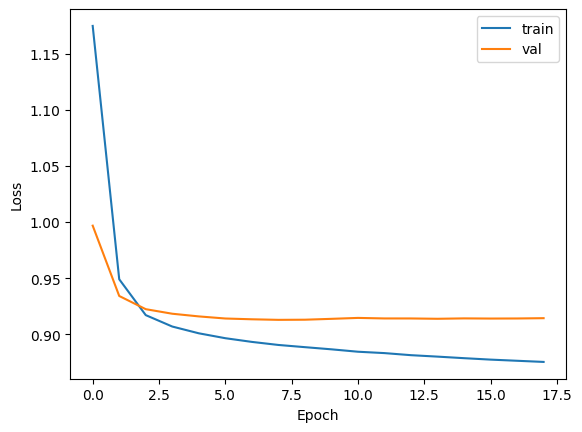

In [14]:
fig, ax = plt.subplots()
ax.plot(H.history['loss'], label='train')
ax.plot(H.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

### Empiezo hacer el modelo 2D imágenes

Importo las librerías necesarias para el modelo 2D Imagenes

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

Igual que el modelo 1D, hago una semilla para reproducibilidad y cargo el dataset de imágenes

In [16]:
np.random.seed(10)
tf.random.set_seed(10)

DATASET_DIR = "/Users/juandiego/Documents/study/keepcoding/deep_learning/datasets"
IMG_PATH = os.path.join(DATASET_DIR, "hmnist_28_28_RGB.csv")
META_PATH = os.path.join(DATASET_DIR, "HAM10000_metadata.csv")

df_img = pd.read_csv(IMG_PATH)

Busca de dónde sacar la columna de etiquetas label - dx. Si ya viene en el DataFrame, la usa. Si no viene, intenta obtenerla cruzando el DataFrame con el archivo de metadata usando image_id. Si no encuentra ninguna etiqueta, lanza un error.

In [17]:
label_col = None
if 'label' in df_img.columns:
    label_col = 'label'
elif 'dx' in df_img.columns:
    label_col = 'dx'

if label_col is not None:
    y_raw = df_img[label_col]
    X_flat = df_img.drop(columns=[label_col, 'image_id'], errors='ignore').values
else:
    if 'image_id' in df_img.columns and os.path.exists(META_PATH):
        meta = pd.read_csv(META_PATH)[['image_id', 'dx']]
        dfm = df_img.merge(meta, on='image_id', how='inner')
        y_raw = dfm['dx']
        X_flat = dfm.drop(columns=['dx', 'image_id'], errors='ignore').values
    else:
        raise ValueError('No se pudo determinar las etiquetas en el DataFrame.')

Tomo los datos planos de las imágenes, calcula el tamaño de la imagen, y reconstruye las imágenes normalizándolas a valores entre 0 y 1.

In [18]:
n_samples = X_flat.shape[0]
n_features = X_flat.shape[1]
img_dim = int(np.sqrt(n_features // 3))
X_img = X_flat.reshape(n_samples, img_dim, img_dim, 3).astype('float32') / 255.0

Convierto las etiquetas en texto y_raw a números enteros y luego a formato one-hot para entrenar

In [19]:
le2d = LabelEncoder()
y_int = le2d.fit_transform(y_raw)
num_classes_2d = len(le2d.classes_)
y_onehot = to_categorical(y_int, num_classes_2d)

Imprime la forma del tensor de imágenes y la lista de clases del dataset.

In [20]:
print('Imágenes:', X_img.shape, '| Clases:', list(le2d.classes_))

Imágenes: (10015, 28, 28, 3) | Clases: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


Divido las imágenes X_img y sus etiquetas one-hot, y_onehot en train, validation y test, usando estratificación para mantener el balance de clases

In [21]:
X_train2d, X_test2d, y_train2d, y_test2d = train_test_split(
    X_img, y_onehot, test_size=0.30, random_state=42, stratify=y_int
)
y_train_int2d = np.argmax(y_train2d, axis=1)
X_train2d, X_val2d, y_train2d, y_val2d = train_test_split(
    X_train2d, y_train2d, test_size=0.30, random_state=42, stratify=y_train_int2d
)

In [22]:
print('Split 2D -> train:', X_train2d.shape, 'val:', X_val2d.shape, 'test:', X_test2d.shape)

Split 2D -> train: (4907, 28, 28, 3) val: (2103, 28, 28, 3) test: (3005, 28, 28, 3)


Creo la red neuronal convolucional para clasificar las imágenes
* Primero defino la arquitectura de la red, aplique  una convulcion de 32 y el maxpooling para reducir la dimencionalidad, y un bloque de 64 para
que pueda aprender caracteristicas mas complejas, tambien agregue una capa de dropout para evitar overfitting, y una capa densa de 128 neuronas.
* Compilo el modelo, usando categorical crossentropy como función de pérdida y accuracy como métrica.
* Aplico early stopping para detener el entrenamiento cuando la pérdida de validación no mejore en 10 épocas.
* Entreno el modelo usando el conjunto de entrenamiento aumentado, y valido con el conjunto de validación.

In [23]:


model2d = Sequential([
    Input(shape=(img_dim, img_dim, 3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes_2d, activation='softmax')
])

model2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early2d = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train2d)

H2d = model2d.fit(
    datagen.flow(X_train2d, y_train2d, batch_size=64),
    validation_data=(X_val2d, y_val2d),
    epochs=50,
    callbacks=[early2d],
    verbose=1
)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6572 - loss: 1.1347 - val_accuracy: 0.6695 - val_loss: 1.0103
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6690 - loss: 1.0037 - val_accuracy: 0.6695 - val_loss: 0.9593
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6717 - loss: 0.9578 - val_accuracy: 0.6743 - val_loss: 0.9061
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6733 - loss: 0.9281 - val_accuracy: 0.6762 - val_loss: 0.8754
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6754 - loss: 0.9095 - val_accuracy: 0.6719 - val_loss: 0.8780
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6727 - loss: 0.9008 - val_accuracy: 0.6819 - val_loss: 0.8618
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6756 - loss: 0.8858 - val_accuracy: 0.6748 - val_loss: 0.9106
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6796 - loss: 0.8649 - val_accuracy: 0.6738 - val_l

La grafica del entrenamiento se puede observar llega a un accuracy de 0.76, se logra notar que entre mas epocas va avanzando trata de hacer un overfitting, ya que la perdida de entrenamiento es menor que la de validacion, Por lo tanto el stop early se activa antes de llegar a la ultima epoca que seria 50.

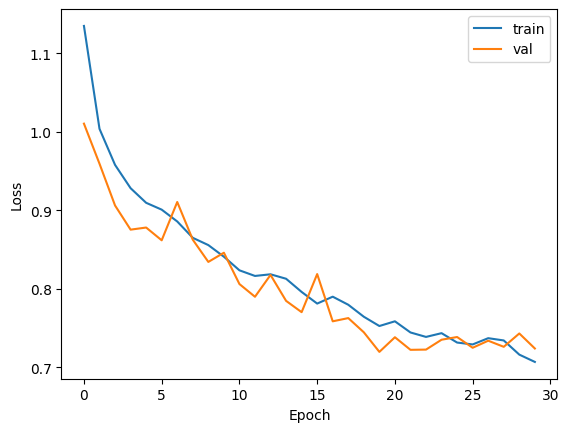

In [24]:
fig, ax = plt.subplots()
ax.plot(H2d.history['loss'], label='train')
ax.plot(H2d.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

evaluación final del modelo usando el conjunto de prueba

In [25]:
test_pred2d = model2d.predict(X_test2d)
test_pred_i2d = np.argmax(test_pred2d, axis=1)
y_test_i2d = np.argmax(y_test2d, axis=1)
print('Matriz de confusión (test 2D):')
print(confusion_matrix(y_test_i2d, test_pred_i2d))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Matriz de confusión (test 2D):
[[   2   30   34    0   28    0    4]
 [   0   89   11    0   51    1    2]
 [   0   28  125    0  158    1   18]
 [   0   14    7    0   12    0    1]
 [   0   27   48    0 1909    2   26]
 [   0    4    0    0   17   21    1]
 [   0    4   44    0  219    1   66]]


In [26]:
val_pred2d = model2d.predict(X_val2d)
val_pred_i2d = np.argmax(val_pred2d, axis=1)
y_val_i2d = np.argmax(y_val2d, axis=1)
print('Matriz de confusión (val 2D):')
print(confusion_matrix(y_val_i2d, val_pred_i2d))

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Matriz de confusión (val 2D):
[[   0   29   18    0   20    0    2]
 [   1   62   15    0   29    0    1]
 [   0   16   77    0  128    0   10]
 [   0   12    2    0    9    0    1]
 [   0   17   34    0 1340    2   15]
 [   0    4    1    0   14   10    1]
 [   0   11   26    0  147    0   49]]


### Empiezo hacer el modelo  Late Fusion

Nuevamente importo lo importante para entrenar el modelo

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


Genero las predicciones del modelo para los tres subconjuntos: entrenamiento, validación y prueba. Esto permite evaluar el rendimiento del modelo en cada uno de ellos

In [28]:
train_pred_1d = model.predict(X_train_t)
val_pred_1d   = model.predict(X_val_t)
test_pred_1d  = model.predict(X_test_t)

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step


Genero las predicciones del modelo convolucional sobre los tres subconjuntos: entrenamiento, validación y prueba

In [29]:
train_pred_2d = model2d.predict(X_train2d)
val_pred_2d   = model2d.predict(X_val2d)
test_pred_2d  = model2d.predict(X_test2d)

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Se combinan las predicciones del modelo 1D y del modelo 2D

In [30]:
X_train_late = np.concatenate([train_pred_1d, train_pred_2d], axis=1)
X_val_late   = np.concatenate([val_pred_1d,   val_pred_2d],   axis=1)
X_test_late  = np.concatenate([test_pred_1d,  test_pred_2d],  axis=1)

Se construye y entrena el modelo de late fusion, cuyo objetivo es aprender una combinación óptima de las predicciones generadas por el modelo de metadatos y el modelo basado en imágenes. La arquitectura consiste en una red densa con capas ocultas de 64 y 32 neuronas, regularizada con dropout. El modelo se entrena con cross-entropy y se valida con un conjunto independiente, utilizando early stopping para evitar sobreajuste. Este clasificador final produce la predicción combinada del sistema multimodal.

In [31]:
late_model = Sequential([
    Input(shape=(X_train_late.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

late_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

early_late = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

H_late = late_model.fit(
    X_train_late, y_train_o,
    validation_data=(X_val_late, y_val_o),
    epochs=100,
    batch_size=32,
    callbacks=[early_late],
    verbose=1
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - accuracy: 0.6411 - loss: 1.2470 - val_accuracy: 0.6838 - val_loss: 0.9782
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6933 - loss: 1.0046 - val_accuracy: 0.6966 - val_loss: 0.9495
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.6964 - loss: 0.9770 - val_accuracy: 0.6971 - val_loss: 0.9421
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.6976 - loss: 0.9744 - val_accuracy: 0.6961 - val_loss: 0.9391
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.6957 - loss: 0.9664 - val_accuracy: 0.6961 - val_loss: 0.9357
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6945 - loss: 0.9565 - val_accuracy: 0.6947 - val_loss: 0.9338
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6929 - loss: 0.9571 - val_accuracy: 0.6966 - val_loss: 0.9331
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6996 - loss: 0

La grafica podemos ver llega a un accuracy del 70%, nuevamente el stop early se activa antes de llegar a 100 epocas, habriendo un sobre ajuste muy pequeño

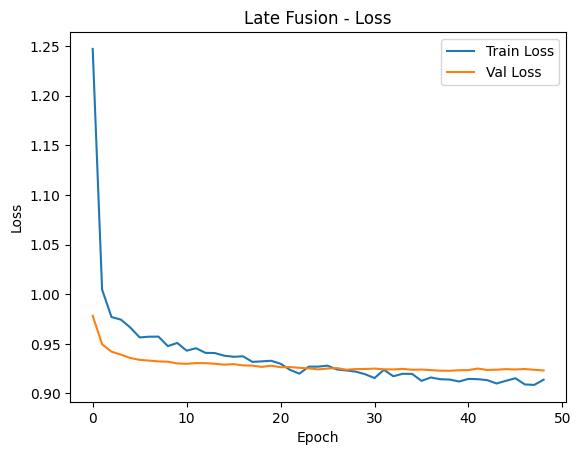

In [32]:
history = H_late.history
fig, ax = plt.subplots()

ax.plot(history['loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Val Loss')
ax.set_title('Late Fusion - Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()


In [33]:
val_pred_late = late_model.predict(X_val_late)
val_pred_i = np.argmax(val_pred_late, axis=1)
y_val_i = np.argmax(y_val_o, axis=1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


In [34]:
val_pred_late = late_model.predict(X_val_late)
val_pred_i = np.argmax(val_pred_late, axis=1)
y_val_i = np.argmax(y_val_o, axis=1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


In [64]:
val_pred_early = early_model.predict(X_val_early)
val_pred_i = np.argmax(val_pred_early, axis=1)
y_val_i = np.argmax(y_val_o, axis=1)

print(classification_report(y_val_i, val_pred_i, target_names=list(le.classes_)))
print(confusion_matrix(y_val_i, val_pred_i))

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        69
         bcc       0.20      0.02      0.03       108
         bkl       0.36      0.44      0.40       231
          df       0.00      0.00      0.00        24
         mel       0.17      0.02      0.04       233
          nv       0.76      0.96      0.85      1408
        vasc       0.00      0.00      0.00        30

    accuracy                           0.69      2103
   macro avg       0.21      0.21      0.19      2103
weighted avg       0.58      0.69      0.62      2103

[[   0    0   30    0    4   35    0]
 [   0    2   47    0    1   58    0]
 [   0    4  102    0    7  118    0]
 [   0    0    1    0    0   23    0]
 [   0    1   53    0    5  174    0]
 [   0    3   43    0   12 1350    0]
 [   0    0    8    0    0   22    0]]


/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

In [65]:
test_pred_early = early_model.predict(X_test_early)
test_pred_i = np.argmax(test_pred_early, axis=1)
y_test_i = np.argmax(y_test_o, axis=1)

print(classification_report(y_test_i, test_pred_i, target_names=list(le.classes_)))
print(confusion_matrix(y_test_i, test_pred_i))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        98
         bcc       0.33      0.03      0.06       154
         bkl       0.33      0.45      0.38       330
          df       0.00      0.00      0.00        34
         mel       0.18      0.02      0.04       334
          nv       0.76      0.95      0.84      2012
        vasc       0.00      0.00      0.00        43

    accuracy                           0.69      3005
   macro avg       0.23      0.21      0.19      3005
weighted avg       0.58      0.69      0.61      3005

[[   0    0   54    0    6   38    0]
 [   0    5   60    0    4   85    0]
 [   0    4  148    0    6  172    0]
 [   0    0    2    0    0   32    0]
 [   0    2   86    0    7  239    0]
 [   0    4   89    0   16 1903    0]
 [   0    0    5    0    0   38    0]]


/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

### Empiezo hacer el modelo early Fusion

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

primero obligo al modelo a tomar forma mediante un predict(), luego creo la versión recortada con las capas deseadas, y finalmente construyes ese submodelo con otro predict. Esto me asegura que ambos extractores tengan entradas y salidas bien definidas antes de usarlos.

In [55]:
_ = model.predict(X_train_t[:1])
_ = model2d.predict(X_train2d[:1])
model1d_features = Sequential(model.layers[:-1])
_ = model1d_features.predict(X_train_t[:1])
model2d_features = Sequential(model2d.layers[:-1])
_ = model2d_features.predict(X_train2d[:1])

print("Shapes de features:")
print("1D:", model1d_features.output_shape)
print("2D:", model2d_features.output_shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Shapes de features:
1D: (1, 32)
2D: (1, 128)


Utilizo los modelos previamente entrenados, una para datos 1D y otra para datos 2D.
Después de recortar cada modelo para quedarme solo con las capas internas, paso cada conjunto de datos completo por cada uno de ellos.

In [56]:
train_feat_1d = model1d_features.predict(X_train_t)
val_feat_1d   = model1d_features.predict(X_val_t)
test_feat_1d  = model1d_features.predict(X_test_t)

train_feat_2d = model2d_features.predict(X_train2d)
val_feat_2d   = model2d_features.predict(X_val2d)
test_feat_2d  = model2d_features.predict(X_test2d)

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [57]:
X_train_early = np.concatenate([train_feat_1d, train_feat_2d], axis=1)
X_val_early   = np.concatenate([val_feat_1d,   val_feat_2d],   axis=1)
X_test_early  = np.concatenate([test_feat_1d,  test_feat_2d],  axis=1)

print("Shapes Early Fusion:")
print("Train:", X_train_early.shape)
print("Val:  ", X_val_early.shape)
print("Test: ", X_test_early.shape)

Shapes Early Fusion:
Train: (4907, 160)
Val:   (2103, 160)
Test:  (3005, 160)


esto es una red completamente conectada donde la entrada es el vector resultante de la fusión temprana.
La arquitectura se limita a capas densas porque los extractores 1D y 2D ya hicieron el trabajo de representación, aquí solo clasifico ese vector. Controla sobreajuste monitorizando la pérdida de validación y restaurando el mejor punto del entrenamiento.

In [62]:
early_model = Sequential([
    Input(shape=(X_train_early.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

early_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

H_early = early_model.fit(
    X_train_early, y_train_o,
    validation_data=(X_val_early, y_val_o),
    epochs=100,
    batch_size=32,
    callbacks=[early_es],
    verbose=1
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6684 - loss: 1.0915 - val_accuracy: 0.6942 - val_loss: 0.9500
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.6929 - loss: 0.9862 - val_accuracy: 0.6942 - val_loss: 0.9351
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.6935 - loss: 0.9631 - val_accuracy: 0.6971 - val_loss: 0.9306
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.6953 - loss: 0.9489 - val_accuracy: 0.6947 - val_loss: 0.9273
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.6959 - loss: 0.9467 - val_accuracy: 0.6933 - val_loss: 0.9230
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6990 - loss: 0.9333 - val_accuracy: 0.6976 - val_loss: 0.9215
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.6976 - loss: 0.9345 - val_accuracy: 0.6957 - val_loss: 0.9193
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.7010 - loss: 0.9

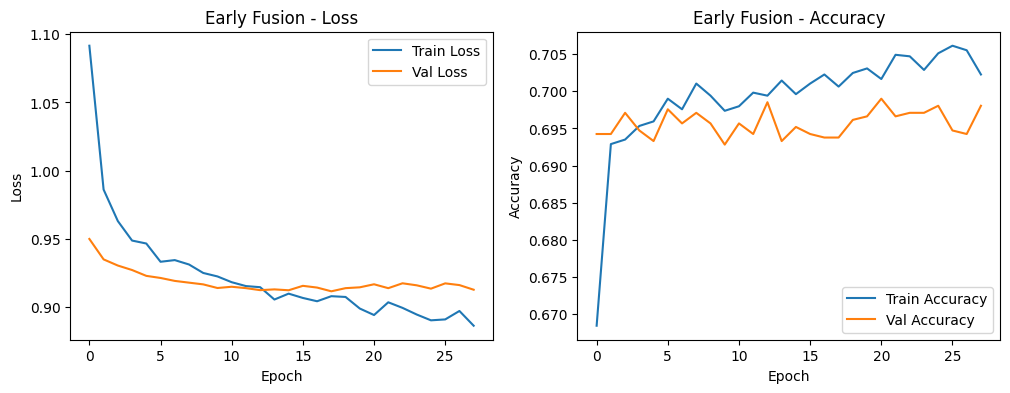

In [63]:
history = H_early.history
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history['loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss')
ax[0].set_title('Early Fusion - Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history['accuracy'], label='Train Accuracy')
ax[1].plot(history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Early Fusion - Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [60]:
val_pred_early = early_model.predict(X_val_early)
val_pred_i = np.argmax(val_pred_early, axis=1)
y_val_i = np.argmax(y_val_o, axis=1)

print(classification_report(y_val_i, val_pred_i, target_names=list(le.classes_)))
print(confusion_matrix(y_val_i, val_pred_i))

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        69
         bcc       0.00      0.00      0.00       108
         bkl       0.37      0.44      0.40       231
          df       0.00      0.00      0.00        24
         mel       0.19      0.03      0.06       233
          nv       0.76      0.96      0.85      1408
        vasc       0.00      0.00      0.00        30

    accuracy                           0.70      2103
   macro avg       0.19      0.20      0.19      2103
weighted avg       0.57      0.70      0.62      2103

[[   0    0   32    0    4   33    0]
 [   0    0   44    0    6   58    0]
 [   0    0  101    0   10  120    0]
 [   0    0    1    0    0   23    0]
 [   0    1   49    0    8  175    0]
 [   0    1   36    0   15 1356    0]
 [   0    0    8    0    0   22    0]]


/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

In [61]:
test_pred_early = early_model.predict(X_test_early)
test_pred_i = np.argmax(test_pred_early, axis=1)
y_test_i = np.argmax(y_test_o, axis=1)

print(classification_report(y_test_i, test_pred_i, target_names=list(le.classes_)))
print(confusion_matrix(y_test_i, test_pred_i))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        98
         bcc       0.00      0.00      0.00       154
         bkl       0.35      0.44      0.39       330
          df       0.00      0.00      0.00        34
         mel       0.27      0.06      0.10       334
          nv       0.76      0.95      0.84      2012
        vasc       0.00      0.00      0.00        43

    accuracy                           0.69      3005
   macro avg       0.20      0.21      0.19      3005
weighted avg       0.58      0.69      0.62      3005

[[   0    0   53    0    8   37    0]
 [   0    0   57    0    8   89    0]
 [   0    0  145    0   15  170    0]
 [   0    0    1    0    2   31    0]
 [   0    0   72    0   21  241    0]
 [   0    0   79    0   24 1909    0]
 [   0    0    5    0    0   38    0]]


/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juandiego/Documents/study/keepcoding/deep_learning/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi